# Stock Trading Strategy with ARIMA model

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima # for determining ARIMA orders

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf

from backtesting import Strategy, Backtest
from backtesting.lib import crossover

import time
from datetime import datetime, date
from pytz import timezone

Loading BokehJS ...

## Getting data and clean it up

In [2]:
# Getting the last 6 years data at once
Stock = 'SPY'
data = yf.download(Stock, period="6y")

data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-03-06,209.419998,209.940002,207.100006,207.500000,184.588028,188128000
2015-03-09,207.740005,208.789993,207.550003,208.360001,185.353058,89818900
2015-03-10,206.710007,206.809998,204.929993,204.979996,182.346252,157121300
2015-03-11,205.289993,205.500000,204.399994,204.500000,181.919250,110145700
2015-03-12,205.259995,207.179993,205.199997,207.100006,184.232162,93993500


In [3]:
data = data.asfreq('D')
data = data.ffill()

In [4]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-03-06,209.419998,209.940002,207.100006,207.500000,184.588028,188128000.0
2015-03-07,209.419998,209.940002,207.100006,207.500000,184.588028,188128000.0
2015-03-08,209.419998,209.940002,207.100006,207.500000,184.588028,188128000.0
2015-03-09,207.740005,208.789993,207.550003,208.360001,185.353058,89818900.0
2015-03-10,206.710007,206.809998,204.929993,204.979996,182.346252,157121300.0
2015-03-11,205.289993,205.500000,204.399994,204.500000,181.919250,110145700.0
2015-03-12,205.259995,207.179993,205.199997,207.100006,184.232162,93993500.0
2015-03-13,206.770004,207.929993,204.580002,205.830002,183.102432,162410900.0
2015-03-14,206.770004,207.929993,204.580002,205.830002,183.102432,162410900.0


In [5]:
data.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-24,386.329987,392.230011,385.269989,391.769989,391.769989,72433900.0
2021-02-25,390.410004,391.880005,380.779999,382.329987,382.329987,146670500.0
2021-02-26,384.350006,385.579987,378.230011,380.359985,380.359985,152534900.0
2021-02-27,384.350006,385.579987,378.230011,380.359985,380.359985,152534900.0
2021-02-28,384.350006,385.579987,378.230011,380.359985,380.359985,152534900.0
2021-03-01,385.589996,390.920013,380.570007,389.579987,389.579987,104945700.0
2021-03-02,389.820007,390.070007,386.000000,386.540009,386.540009,79389200.0
2021-03-03,385.790009,386.829987,381.309998,381.420013,381.420013,119482700.0
2021-03-04,381.220001,384.000000,371.880005,376.700012,376.700012,182856500.0


In [6]:
data.index

DatetimeIndex(['2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09',
               '2015-03-10', '2015-03-11', '2015-03-12', '2015-03-13',
               '2015-03-14', '2015-03-15',
               ...
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27',
               '2021-02-28', '2021-03-01', '2021-03-02', '2021-03-03',
               '2021-03-04', '2021-03-05'],
              dtype='datetime64[ns]', name='Date', length=2192, freq='D')

### Making a function to predict stock price with ARIMA Model

In [7]:
# Making a function to create prediction of days future
def arima_fcst(p, q, d, data, days):
    model = ARIMA(data['Close'], order=(p,q,d))
    results = model.fit()
    fcst = results.predict(len(data),len(data)+40, dynamic=False, typ='levels')  #.rename('ARIMA Forecast') #levels, linear
    return fcst[days]

In [8]:
# Calculating ARIMA prediction based on selected parameters
ARIMA_pred = []

p = 0
q = 1
d = 3
days = 10

for n in range(len(data)-50):
    ARIMA_pred.append(arima_fcst(p, q, d, data.iloc[0+n:50+n], days))

In [9]:
# Since there is no ARIMA forecast for the first "days", removing the rows of the first "days"
data2 = data[-len(ARIMA_pred):]

In [10]:
data2['ARIMA_Pred'] = ARIMA_pred

In [11]:
data2.head()

,Open,High,Low,Close,Adj Close,Volume,ARIMA_Pred
Date,,,,,,,
2015-04-25,211.660004,211.970001,211.110001,211.649994,189.120255,61327400.0,212.365592
2015-04-26,211.660004,211.970001,211.110001,211.649994,189.120255,61327400.0,212.504722
2015-04-27,212.330002,212.479996,210.539993,210.770004,188.333908,79358100.0,212.603698
2015-04-28,210.740005,211.500000,209.330002,211.440002,188.932602,86863500.0,210.787460
2015-04-29,210.369995,211.289993,209.600006,210.570007,188.155212,125684900.0,212.887301


In [12]:
data2.tail()

,Open,High,Low,Close,Adj Close,Volume,ARIMA_Pred
Date,,,,,,,
2021-03-01,385.589996,390.920013,380.570007,389.579987,389.579987,104945700.0,380.212468
2021-03-02,389.820007,390.070007,386.000000,386.540009,386.540009,79389200.0,394.328330
2021-03-03,385.790009,386.829987,381.309998,381.420013,381.420013,119482700.0,389.428386
2021-03-04,381.220001,384.000000,371.880005,376.700012,376.700012,182856500.0,382.052420
2021-03-05,380.459991,384.760010,372.640015,383.630005,383.630005,151959800.0,377.120511


In [13]:
data2['Arima_Signal'] = data2['ARIMA_Pred']/data2['Close']

In [14]:
data2.tail()

,Open,High,Low,Close,Adj Close,Volume,ARIMA_Pred,Arima_Signal
Date,,,,,,,,
2021-03-01,385.589996,390.920013,380.570007,389.579987,389.579987,104945700.0,380.212468,0.975955
2021-03-02,389.820007,390.070007,386.000000,386.540009,386.540009,79389200.0,394.328330,1.020149
2021-03-03,385.790009,386.829987,381.309998,381.420013,381.420013,119482700.0,389.428386,1.020996
2021-03-04,381.220001,384.000000,371.880005,376.700012,376.700012,182856500.0,382.052420,1.014209
2021-03-05,380.459991,384.760010,372.640015,383.630005,383.630005,151959800.0,377.120511,0.983032


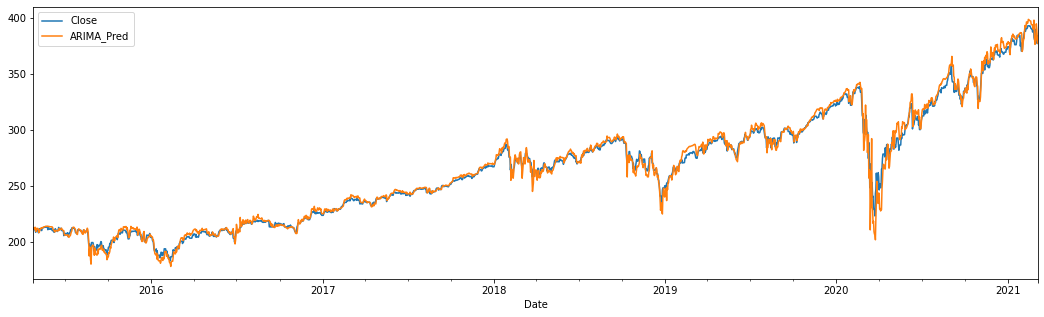

In [15]:
data2[['Close', 'ARIMA_Pred']].plot(figsize=(18,5))

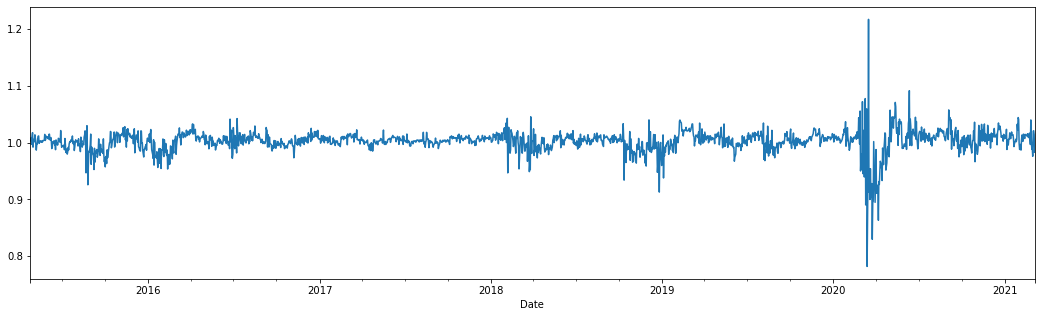

In [16]:
data2['Arima_Signal'].plot(figsize=(18,5))

### Making trading strategy based on ARIMA 5days prediction

In [17]:
def get_signal(data):
    return data['Arima_Signal']

In [18]:
class ARIMA_Pred(Strategy):
    low = 0.98
    high = 1.02 
    long_only = 1
    
    def init(self):
        self.signal = self.I(get_signal, self.data)
            
    def next(self):
        if self.signal > self.high:  
            if self.long_only == 0:
                self.position.close()
            self.buy()

        elif self.signal < self.low:
            self.position.close()
            if self.long_only == 0:
                self.sell()

### Backtesting ARIMA strategy

In [19]:
days_2021 = date.today() - date(2021, 1, 1)

In [20]:
# Spliting the data based
Mo6 = data2[-183:]
Yr1 = data2[-365:]
Yr2 = data2[-730:]
CY20 = data2[-days_2021.days-366:-days_2021.days]
CY19 = data2[-days_2021.days-366-365:-days_2021.days-366]
CY18 = data2[-days_2021.days-366-365-365:-days_2021.days-366-365]
CY17 = data2[-days_2021.days-366-365-365-365:-days_2021.days-366-365-365]
CY16 = data2[-days_2021.days-366-365-365-365-366:-days_2021.days-366-365-365-365]

In [21]:
periods = [Mo6, Yr1, Yr2, CY20, CY19, CY18, CY17, CY16]

# Running backtest for each period

for period in periods:
    # Run backtesting
    bt = Backtest(period, ARIMA_Pred, cash=100_000, commission=0)
    stats = bt.run()

    # Display stats and plot results
    print(stats)
    bt.plot()

Start                     2020-09-04 00:00:00
End                       2021-03-05 00:00:00
Duration                    182 days 00:00:00
Exposure Time [%]                     78.6885
Equity Final [$]                        98938
Equity Peak [$]                        101049
Return [%]                             -1.062
Buy & Hold Return [%]                 11.9859
Return (Ann.) [%]                    -2.10701
Volatility (Ann.) [%]                 14.7743
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -10.3718
Avg. Drawdown [%]                      -4.535
Max. Drawdown Duration      156 days 00:00:00
Avg. Drawdown Duration       59 days 00:00:00
# Trades                                    4
Win Rate [%]                               25
Best Trade [%]                        11.3994
Worst Trade [%]                      -6.80381
Avg. Trade [%]                    

Start                     2020-03-06 00:00:00
End                       2021-03-05 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                     76.1644
Equity Final [$]                       114080
Equity Peak [$]                        119189
Return [%]                            14.0805
Buy & Hold Return [%]                 28.9686
Return (Ann.) [%]                     14.0805
Volatility (Ann.) [%]                 20.7418
Sharpe Ratio                         0.678846
Sortino Ratio                         1.00779
Calmar Ratio                          1.05986
Max. Drawdown [%]                    -13.2852
Avg. Drawdown [%]                    -3.47455
Max. Drawdown Duration      184 days 00:00:00
Avg. Drawdown Duration       34 days 00:00:00
# Trades                                    7
Win Rate [%]                          28.5714
Best Trade [%]                         13.063
Worst Trade [%]                      -3.58717
Avg. Trade [%]                    

Start                     2019-03-07 00:00:00
End                       2021-03-05 00:00:00
Duration                    729 days 00:00:00
Exposure Time [%]                     72.3288
Equity Final [$]                       107561
Equity Peak [$]                        112384
Return [%]                            7.56137
Buy & Hold Return [%]                 39.4967
Return (Ann.) [%]                      3.7118
Volatility (Ann.) [%]                  16.171
Sharpe Ratio                         0.229534
Sortino Ratio                        0.302721
Calmar Ratio                         0.183846
Max. Drawdown [%]                    -20.1897
Avg. Drawdown [%]                     -2.9666
Max. Drawdown Duration      221 days 00:00:00
Avg. Drawdown Duration       38 days 00:00:00
# Trades                                   14
Win Rate [%]                          28.5714
Best Trade [%]                         13.063
Worst Trade [%]                      -5.43956
Avg. Trade [%]                    

Start                     2020-01-01 00:00:00
End                       2020-12-31 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                     69.6721
Equity Final [$]                        95492
Equity Peak [$]                        103147
Return [%]                           -4.50798
Buy & Hold Return [%]                 16.1623
Return (Ann.) [%]                    -4.49594
Volatility (Ann.) [%]                 18.2309
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -20.1825
Avg. Drawdown [%]                    -6.26061
Max. Drawdown Duration      196 days 00:00:00
Avg. Drawdown Duration       56 days 00:00:00
# Trades                                    9
Win Rate [%]                          22.2222
Best Trade [%]                         13.063
Worst Trade [%]                      -13.1573
Avg. Trade [%]                    

Start                     2019-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                     62.4658
Equity Final [$]                       110714
Equity Peak [$]                        111545
Return [%]                             10.714
Buy & Hold Return [%]                 28.7852
Return (Ann.) [%]                      10.714
Volatility (Ann.) [%]                 10.2655
Sharpe Ratio                          1.04369
Sortino Ratio                         1.60256
Calmar Ratio                          1.01159
Max. Drawdown [%]                    -10.5912
Avg. Drawdown [%]                     -1.2551
Max. Drawdown Duration      221 days 00:00:00
Avg. Drawdown Duration       19 days 00:00:00
# Trades                                    5
Win Rate [%]                               60
Best Trade [%]                        11.3686
Worst Trade [%]                      -5.43956
Avg. Trade [%]                    

Start                     2018-01-01 00:00:00
End                       2018-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                     53.6986
Equity Final [$]                      86495.2
Equity Peak [$]                        103483
Return [%]                           -13.5048
Buy & Hold Return [%]                -6.34789
Return (Ann.) [%]                    -13.5048
Volatility (Ann.) [%]                 9.94689
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -18.4587
Avg. Drawdown [%]                    -8.14855
Max. Drawdown Duration      179 days 00:00:00
Avg. Drawdown Duration       82 days 00:00:00
# Trades                                    5
Win Rate [%]                               40
Best Trade [%]                        2.31793
Worst Trade [%]                      -11.3626
Avg. Trade [%]                    

Start                     2017-01-01 00:00:00
End                       2017-12-31 00:00:00
Duration                    364 days 00:00:00
Exposure Time [%]                     78.0822
Equity Final [$]                       114843
Equity Peak [$]                        114843
Return [%]                            14.8425
Buy & Hold Return [%]                 19.3844
Return (Ann.) [%]                     14.8425
Volatility (Ann.) [%]                 6.82206
Sharpe Ratio                          2.17567
Sortino Ratio                         3.85544
Calmar Ratio                          7.14203
Max. Drawdown [%]                    -2.07819
Avg. Drawdown [%]                   -0.505515
Max. Drawdown Duration       35 days 00:00:00
Avg. Drawdown Duration        9 days 00:00:00
# Trades                                    1
Win Rate [%]                              100
Best Trade [%]                        14.8693
Worst Trade [%]                       14.8693
Avg. Trade [%]                    

Start                     2016-01-01 00:00:00
End                       2016-12-31 00:00:00
Duration                    365 days 00:00:00
Exposure Time [%]                     72.4044
Equity Final [$]                       102936
Equity Peak [$]                        106708
Return [%]                            2.93593
Buy & Hold Return [%]                  9.6434
Return (Ann.) [%]                     2.92779
Volatility (Ann.) [%]                 9.68628
Sharpe Ratio                         0.302262
Sortino Ratio                        0.425357
Calmar Ratio                         0.486983
Max. Drawdown [%]                     -6.0121
Avg. Drawdown [%]                    -1.24523
Max. Drawdown Duration      138 days 00:00:00
Avg. Drawdown Duration       22 days 00:00:00
# Trades                                    4
Win Rate [%]                               50
Best Trade [%]                        2.74879
Worst Trade [%]                     -0.701878
Avg. Trade [%]                    